In [1]:
import functools
import os
import pandas as pd
import e3x
import flax.linen as nn
import jax
import numpy as np
import optax
# Disable future warnings.
import warnings
import pickle

warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
plt.set_cmap('bwr')

import jax.numpy as jnp
from jax import jit, grad
from jax import vmap
batch_size = 16
NATOMS = 60

/tmp/ipykernel_7248/4180096664.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


<Figure size 640x480 with 0 Axes>

In [2]:
def evaluate_dc(batch, dipo, mono, batch_size, plot=False, rcut=10000):
    esp_dc_pred = esp_mono_loss_pots(dipo, mono, batch['esp'], 
                             batch['vdw_surface'], batch['mono'], 
                             batch_size)

    mono_pred =  esp_loss_pots(batch['positions'], batch['mono'], batch['esp'],
                        batch['vdw_surface'], batch['mono'], batch_size)

    non_zero = np.nonzero(batch["mono"])

    if plot:
    
        plt.scatter(batch["mono"][non_zero], 
                    mono.sum(axis=-1).squeeze()[non_zero])
        loss = esp_loss_eval(batch["mono"][non_zero], mono.sum(axis=-1).squeeze()[non_zero], None)
        plt.title(loss)
        plt.plot([-1,1],[-1,1],c="k",alpha=0.5)
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        ax=plt.gca()
        ax.set_aspect("equal")
        plt.show()
        
        for id in range(batch_size):
            plt.scatter(esp_dc_pred[id][:batch['ngrid'][id]],
                        batch['esp'][id][:batch['ngrid'][id]], alpha=0.1)
     
        ax = plt.gca()
        plt.xlim(-0.1, 0.1)
        plt.ylim(-0.1, 0.1)
        plt.plot([-1,1],[-1,1],c="k",alpha=0.5)
        ax.set_aspect("equal")
        plt.show()

    esp_errors = []
    
    for mbID in range(batch_size):
        xyzs = batch['positions'].reshape(batch_size,60, 3)
        vdws = batch['vdw_surface'][mbID][:batch['ngrid'][mbID]]
        diff = xyzs[mbID][:, None, :] - vdws[None, :, :]
        r = np.linalg.norm(diff, axis=-1) 
        min_d = np.min(r, axis=-2)
        wheremind = np.where( min_d < rcut, min_d, 0)
        idx_cut = np.nonzero(wheremind)[0]
        loss1 = esp_loss_eval(esp_dc_pred[mbID][:batch['ngrid'][mbID]][idx_cut], 
                      batch['esp'][mbID][:batch['ngrid'][mbID]][idx_cut],
                      batch['ngrid'][mbID])
        loss2 = esp_loss_eval(mono_pred[mbID][:batch['ngrid'][mbID]][idx_cut], 
                      batch['esp'][mbID][:batch['ngrid'][mbID]][idx_cut],
                      batch['ngrid'][mbID])
        esp_errors.append([loss1, loss2])

        if plot:
            
            fig = plt.figure(figsize=(12,6))
            
            ax1 = fig.add_subplot(151, projection='3d')
            s = ax1.scatter(*batch['vdw_surface'][mbID][:batch['ngrid'][mbID]][idx_cut].T, 
                           c=clip_colors(batch['esp'][mbID][:batch['ngrid'][mbID]][idx_cut]), 
                           vmin=-0.015, vmax=0.015)
            ax1.set_title(f"GT {mbID}")
            
    
            ax2 = fig.add_subplot(152, projection='3d')
            s = ax2.scatter(*batch['vdw_surface'][mbID][:batch['ngrid'][mbID]][idx_cut].T, 
                           c=clip_colors(esp_dc_pred[mbID][:batch['ngrid'][mbID]][idx_cut]), 
                           vmin=-0.015, vmax=0.015)
            ax2.set_title(loss1)
            
            ax4 = fig.add_subplot(153, projection='3d')
            s = ax4.scatter(*batch['vdw_surface'][mbID][:batch['ngrid'][mbID]][idx_cut].T, 
                           c=clip_colors(esp_dc_pred[mbID][:batch['ngrid'][mbID]][idx_cut]
                                        - batch['esp'][mbID][:batch['ngrid'][mbID]][idx_cut]
                                        ), 
                           vmin=-0.015, vmax=0.015)
    
    
            ax3 = fig.add_subplot(154, projection='3d')
            s = ax3.scatter(*batch['vdw_surface'][mbID][:batch['ngrid'][mbID]][idx_cut].T, 
                           c=clip_colors(mono_pred[mbID][:batch['ngrid'][mbID]][idx_cut]), 
                           vmin=-0.015, vmax=0.015)
            ax3.set_title(loss2)
    
            ax5 = fig.add_subplot(155, projection='3d')
            s = ax5.scatter(*batch['vdw_surface'][mbID][:batch['ngrid'][mbID]][idx_cut].T, 
                           c=clip_colors(mono_pred[mbID][:batch['ngrid'][mbID]][idx_cut]
                                        - batch['esp'][mbID][:batch['ngrid'][mbID]][idx_cut]
                                        ), 
                           vmin=-0.015, vmax=0.015)
    
    
    
            for _ in [ax1,ax2,ax3]:
                _.set_xlim(-10,10)
                _.set_ylim(-10,10)
                _.set_zlim(-10,10)
            plt.show()
        
    return esp_errors


In [3]:
from esp_net import prepare_datasets,prepare_batches

def nan_safe_coulomb_potential(q, r):
    potential = jnp.where(jnp.isnan(r) | (r == 0.0), 0.0, q / (r * 1.88973))
    return potential


def calc_esp(charge_positions, charge_values, grid_positions, mono):
    chg_mask = jnp.where(mono != 0, 1.0, 0.0)
    # Expand the grid positions and charge positions to compute all pairwise differences
    diff = grid_positions[:, None, :] - charge_positions[None, :, :]
    # Compute the Euclidean distance between each grid point and each charge
    r = jnp.linalg.norm(diff, axis=-1)
    sum_chg = jnp.sum(chg_mask * charge_values)
    # jax.debug.print("x = {x}", x=sum_chg)
    avg_chg = jnp.sum(chg_mask * charge_values) / jnp.sum(chg_mask)
    new_charge_values = charge_values - avg_chg
    # sum_chg_new = jnp.sum(chg_mask * new_charge_values)
    # jax.debug.print("x2 = {x}", x=sum_chg_new)
    C = nan_safe_coulomb_potential((chg_mask * new_charge_values)[None, :], r)
    V = jnp.sum(C, axis=-1)
    return V

def esp_loss_eval(pred, target, ngrid):
    target = target.flatten()
    esp_non_zero = np.nonzero(target)
    l2_loss = optax.l2_loss(pred[esp_non_zero], target[esp_non_zero])
    esp_loss = np.mean(l2_loss)
    esp_loss = esp_loss * 1  
    return esp_loss
    
batched_electrostatic_potential = vmap(calc_esp, in_axes=(0, 0, 0, 0), out_axes=0)


def clip_colors(c):
    return np.clip(c, -0.015, 0.015)


@functools.partial(jax.jit, static_argnames=('batch_size', 'esp_w'))
def esp_mono_loss(dipo_prediction, mono_prediction, esp_target,
                  vdw_surface, mono, batch_size, esp_w):
    """
    """
    nonzero = jnp.nonzero(mono, size=batch_size * 60)
    l2_loss_mono = optax.l2_loss(mono_prediction.sum(axis=-1), mono)
    mono_loss = jnp.mean(l2_loss_mono[nonzero])

    d = dipo_prediction.reshape(batch_size, NATOMS, 3, n_dcm)
    d = jnp.moveaxis(d, -1, -2)
    d = d.reshape(batch_size, NATOMS * n_dcm, 3)
    mono = jnp.repeat(mono.reshape(batch_size, NATOMS), n_dcm, axis=-1)
    m = mono_prediction.reshape(batch_size, NATOMS * n_dcm)

    batched_pred = batched_electrostatic_potential(d, m, vdw_surface, mono).flatten()
    esp_target = esp_target.flatten()
    esp_non_zero = jnp.nonzero(esp_target, size=batch_size * 3143)

    l2_loss = optax.l2_loss(batched_pred, esp_target)
    esp_loss = jnp.mean(l2_loss[esp_non_zero])
    esp_loss = esp_loss * esp_w
    return esp_loss + mono_loss


def esp_mono_loss_pots(dipo_prediction, mono_prediction, esp_target,
                       vdw_surface, mono, batch_size):
    """
    """
    d = dipo_prediction.reshape(batch_size, NATOMS, 3, n_dcm)
    d = jnp.moveaxis(d, -1, -2)
    d = d.reshape(batch_size, NATOMS * n_dcm, 3)
    mono = jnp.repeat(mono.reshape(batch_size, NATOMS), n_dcm, axis=-1)
    m = mono_prediction.reshape(batch_size, NATOMS * n_dcm)

    batched_pred = batched_electrostatic_potential(d, m, vdw_surface, mono)

    return batched_pred


def esp_loss_pots(dipo_prediction, mono_prediction,
                  esp_target, vdw_surface, mono, batch_size):
    d = dipo_prediction.reshape(batch_size, NATOMS, 3)
    mono = mono.reshape(batch_size, NATOMS)
    m = mono_prediction.reshape(batch_size, NATOMS)
    batched_pred = batched_electrostatic_potential(d, m, vdw_surface, mono)

    return batched_pred


def mean_absolute_error(prediction, target, batch_size):
    nonzero = jnp.nonzero(target, size=batch_size * 60)
    return jnp.mean(jnp.abs(prediction[nonzero] - target[nonzero]))

<Figure size 640x480 with 0 Axes>

In [4]:
NATOMS = 60
class MessagePassingModel(nn.Module):
    features: int = 32
    max_degree: int = 2
    num_iterations: int = 3
    num_basis_functions: int = 8
    cutoff: float = 5.0
    max_atomic_number: int = 17
    n_dcm: int = 4

    def mono(self, atomic_numbers, positions, dst_idx, src_idx, batch_segments,
             batch_size):
        # 1. Calculate displacement vectors.
        positions_dst = e3x.ops.gather_dst(positions, dst_idx=dst_idx)
        positions_src = e3x.ops.gather_src(positions, src_idx=src_idx)
        displacements = positions_src - positions_dst  # Shape (num_pairs, 3).

        # 2. Expand displacement vectors in basis functions.
        basis = e3x.nn.basis(
            # Shape (num_pairs, 1, (max_degree+1)**2, num_basis_functions).
            displacements,
            num=self.num_basis_functions,
            max_degree=self.max_degree,
            radial_fn=e3x.nn.reciprocal_bernstein,
            cutoff_fn=functools.partial(e3x.nn.smooth_cutoff, cutoff=self.cutoff)
        )

        x = e3x.nn.Embed(num_embeddings=self.max_atomic_number + 1,
                         features=self.features)(atomic_numbers)

        # 4. Perform iterations (message-passing + atom-wise refinement).
        for i in range(self.num_iterations):
            # Message-pass.
            if i == self.num_iterations - 1:  # Final iteration.
                y = e3x.nn.MessagePass(max_degree=max_degree,
                                       include_pseudotensors=False
                                       )(x, basis, dst_idx=dst_idx, src_idx=src_idx)
            else:
                y = e3x.nn.MessagePass()(x, basis, dst_idx=dst_idx, src_idx=src_idx)
            y = e3x.nn.add(x, y)
            # Atom-wise refinement MLP.
            y = e3x.nn.Dense(self.features)(y)
            y = e3x.nn.silu(y)
            y = e3x.nn.Dense(self.features)(y)
            # Residual connection.
            x = e3x.nn.add(x, y)

        x = e3x.nn.TensorDense(
            features=n_dcm,
            max_degree=1,
            include_pseudotensors=False,
        )(x)

        atomic_mono = e3x.nn.change_max_degree_or_type(x,
                                                       max_degree=0,
                                                       include_pseudotensors=False)
        element_bias = self.param('element_bias',
                                  lambda rng, shape: jnp.zeros(shape),
                                  (self.max_atomic_number + 1))
        atomic_mono = nn.Dense(n_dcm, use_bias=False,
                               )(atomic_mono)
        atomic_mono = atomic_mono.squeeze(axis=1)
        atomic_mono = atomic_mono.squeeze(axis=1)
        atomic_mono += element_bias[atomic_numbers][:, None]
        
        atomic_dipo = x[:, 1, 1:4, :]
        atomic_dipo = e3x.nn.silu(atomic_dipo)
        # atomic_dipo = jnp.clip(atomic_dipo, a_min=-0.3, a_max=0.3)
        atomic_dipo += positions[:, :, None]

        return atomic_mono, atomic_dipo

    @nn.compact
    def __call__(self, atomic_numbers, positions, dst_idx, src_idx,
                 batch_segments=None, batch_size=None):
        if batch_segments is None:
            batch_segments = jnp.zeros_like(atomic_numbers)
            batch_size = 1

        return self.mono(atomic_numbers, positions, dst_idx, src_idx, batch_segments,
                         batch_size)

In [5]:
def flatten(xss):
    return [x for xs in xss for x in xs]
    
def process_df(errors):
    h2kcal = 627.509
    df = pd.DataFrame(flatten(errors))
    df["model"] = df[0].apply(lambda x: np.sqrt(x)*h2kcal)
    df["mono"] = df[1].apply(lambda x: np.sqrt(x)*h2kcal)
    df["dif"] =  df["model"] - df["mono"]
    return df

# Data

In [6]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(
    0
), 2)
train_data, valid_data = prepare_datasets(
    data_key,
    10000 - 16,
    16,
    filename="data/qm9-esp10000.npz")

R (10000, 60, 3)
Z (10000, 60)
N (10000,)
mono (10000, 60, 1)
esp (10000, 3143)
n_grid (10000,)
vdw_surface (10000, 3143, 3)
10000
...
...
atomic_numbers (9984, 60)
ngrid (9984,)
positions (9984, 60, 3)
mono (9984, 60, 1)
esp (9984, 3143)
vdw_surface (9984, 3143, 3)
...
atomic_numbers (16, 60)
positions (16, 60, 3)
mono (16, 60, 1)
ngrid (16,)
esp (16, 3143)
vdw_surface (16, 3143, 3)


In [7]:
valid_batches = prepare_batches(data_key, valid_data, batch_size)
print(len(valid_batches))

1


In [8]:
train_batches = prepare_batches(data_key, train_data, batch_size)
print(len(train_batches))

624


In [9]:
NTRAINEVAL = 10

In [10]:
from pathlib import Path
import pandas as pd

def get_lowest_loss(path, df=False):
    paths = []
    losses = []
    for _ in Path(path).glob("*.pkl"):
        loss = float((_.stem).split("-")[1])
        paths.append(_)
        losses.append(loss)
    if df:
        return pd.DataFrame([paths, losses]).T.sort_values(1)
    else:
        return pd.DataFrame([paths, losses]).T.sort_values(1).iloc[0][0]
    
get_lowest_loss("checkpoints/dcm1-10000.0/")
    

PosixPath('checkpoints/dcm1-10000.0/1-0.053797438740730286-esp_params.pkl')

In [11]:
get_lowest_loss("checkpoints/dcm2-10000.0/")

PosixPath('checkpoints/dcm2-10000.0/3-0.025417018681764603-esp_params.pkl')

#  DCM1

In [12]:
# Model hyperparameters.
features = 32
max_degree = 2
num_iterations = 3
num_basis_functions = 16
cutoff = 4.0

n_dcm = 1
# Training hyperparameters.
learning_rate = 0.001
batch_size = 16
esp_w = 10.0
restart_params = None
num_epochs = 20

# Create and train model.
message_passing_model = MessagePassingModel(
    features=features,
    max_degree=max_degree,
    num_iterations=num_iterations,
    num_basis_functions=num_basis_functions,
    cutoff=cutoff,
    n_dcm=n_dcm,
)

# params = pd.read_pickle("checkpoints/dcm1-10000.0/1-0.053797438740730286-esp_params.pkl")

params = pd.read_pickle(get_lowest_loss("checkpoints/dcm1-10000.0/"))

# params = pd.read_pickle("checkpoints/dcm1-10.0/8-0.00036029628245159984-esp_params.pkl")

# params = pd.read_pickle("checkpoints/dcm1-100.0/27-0.0014055122155696154-esp_params.pkl")

message_passing_model

MessagePassingModel(
    # attributes
    features = 32
    max_degree = 2
    num_iterations = 3
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 1
)

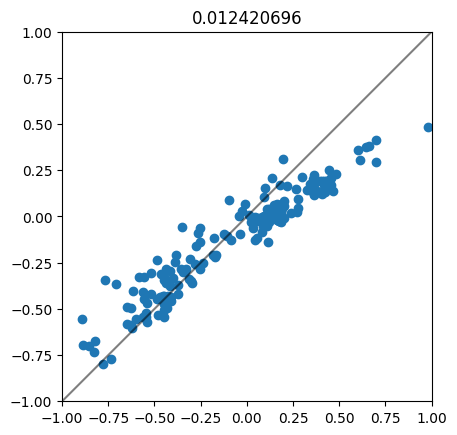

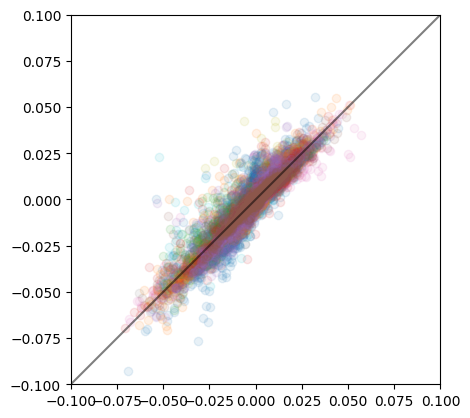

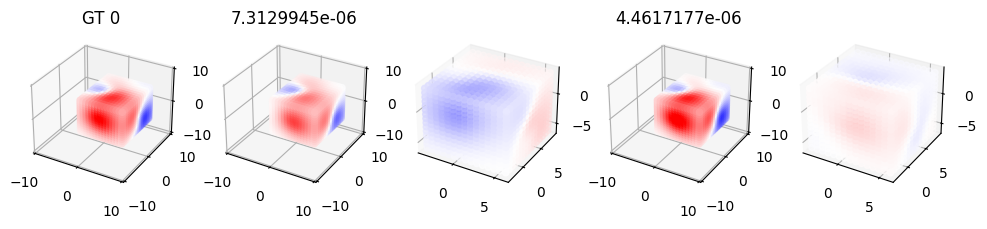

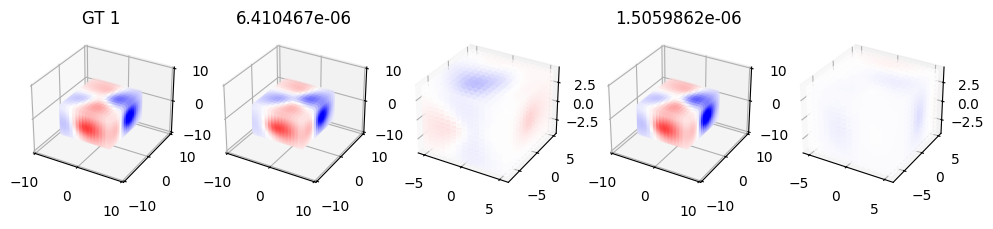

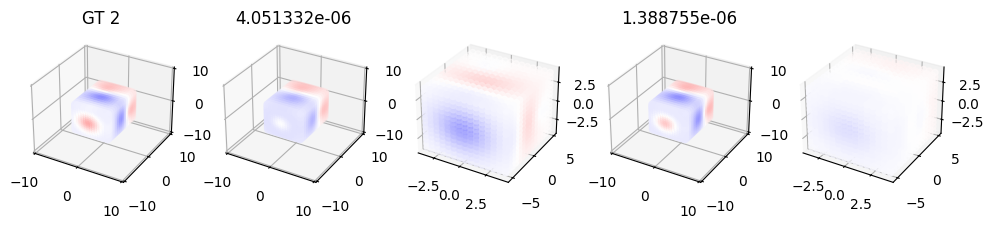

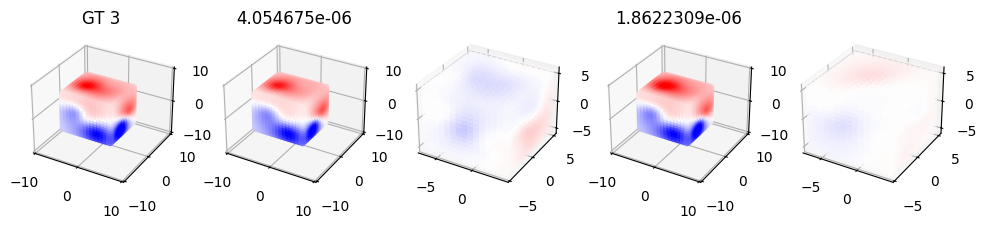

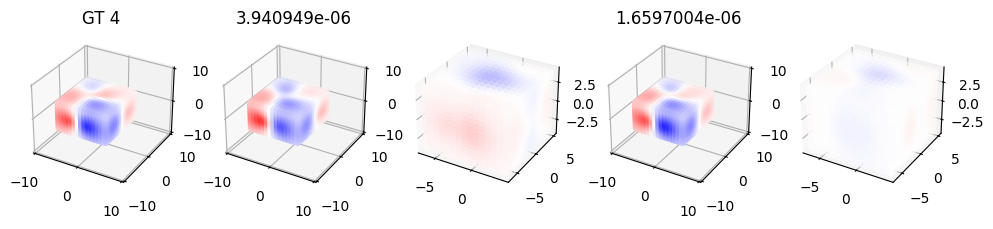

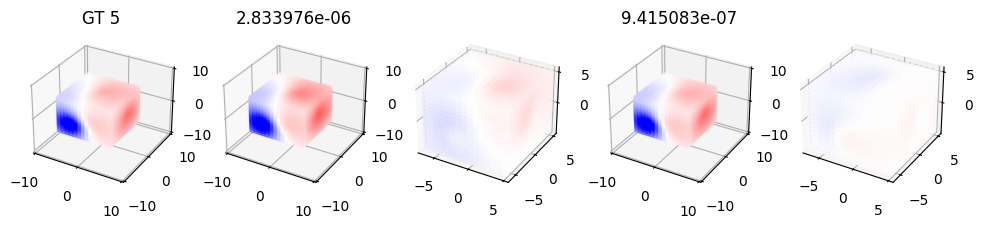

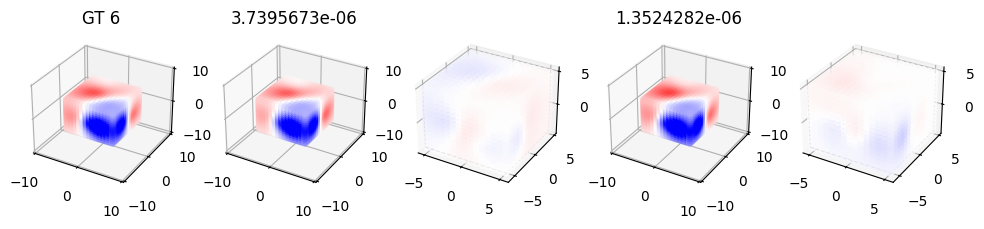

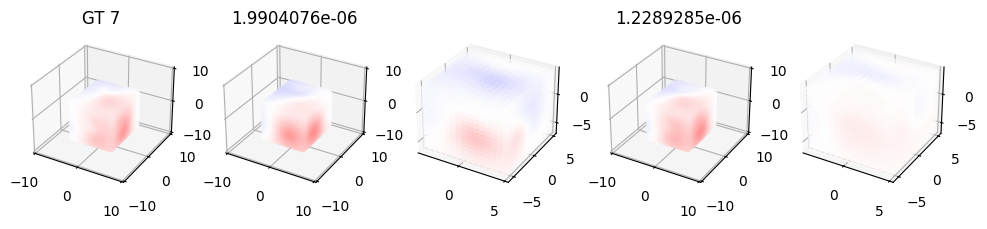

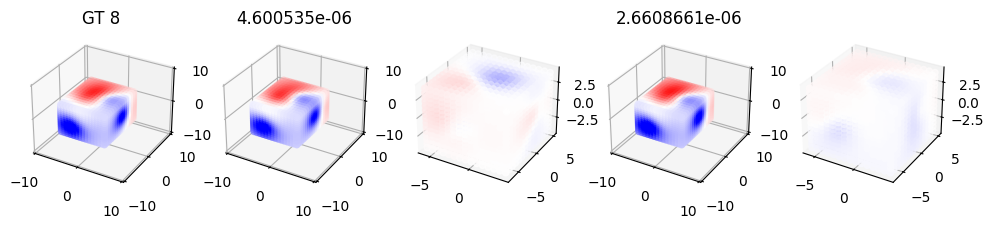

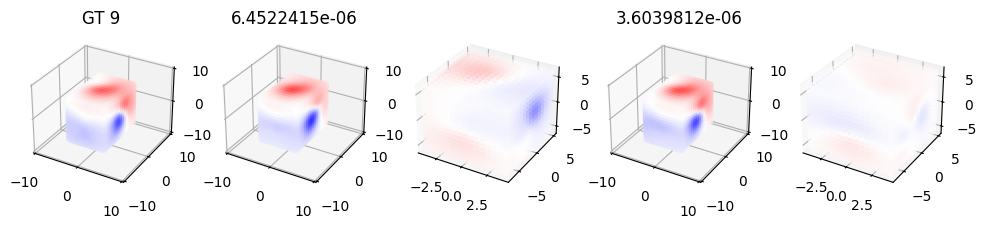

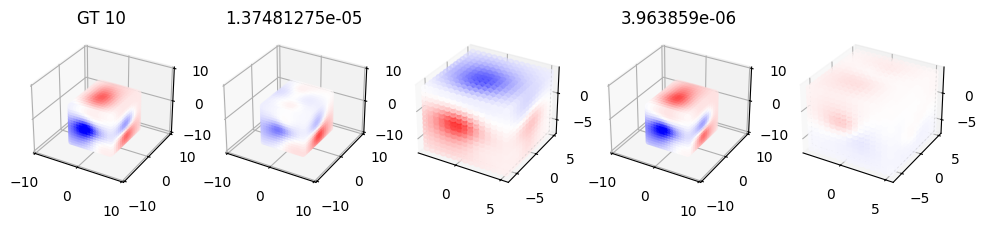

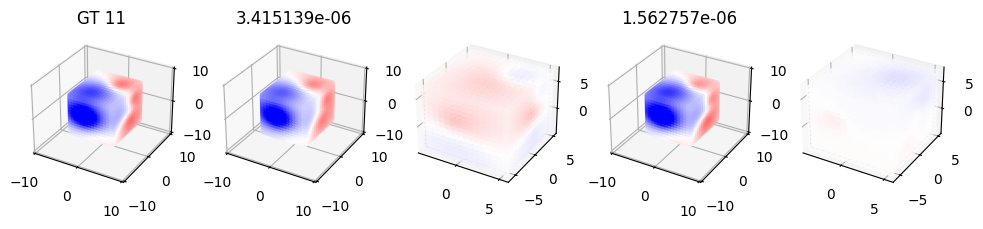

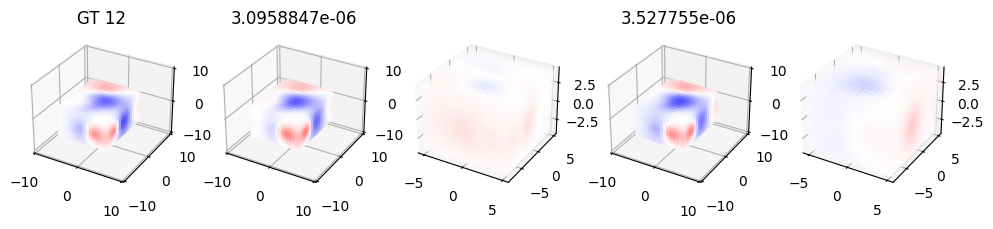

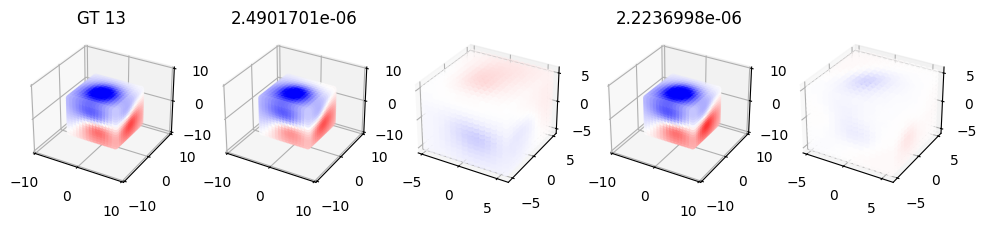

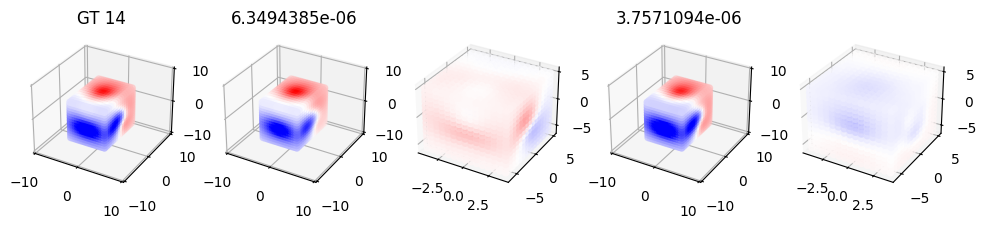

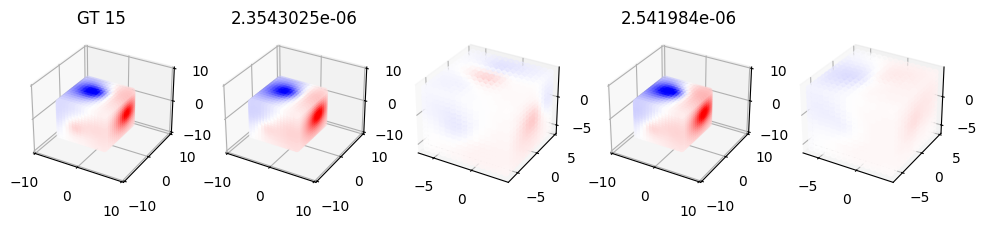

In [13]:
errors_train = []

for batchID in range(1):
    batch = valid_batches[batchID]
    
    mono, dipo = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    errors = evaluate_dc(batch, dipo, mono, batch_size, plot=True)
    errors_train.append(errors)

In [14]:
# errors_train

In [15]:
errors_test = []

for batchID in range(NTRAINEVAL):
    batch = train_batches[batchID]
    
    mono, dipo = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    errors = evaluate_dc(batch, dipo, mono, batch_size)
    errors_test.append(errors)

In [16]:
dcm1_errors = process_df(errors_test)

In [17]:
dcm1_errors.describe()

model        mono         dif
count  160.000000  160.000000  160.000000
mean     1.257426    0.991943    0.265484
std      0.460976    0.302645    0.355222
min      0.619012    0.576099   -0.439593
25%      0.930969    0.782169    0.032687
50%      1.159195    0.930883    0.209040
75%      1.499895    1.102676    0.441029
max      2.954420    2.408691    1.498976

(0.0, 5.0)

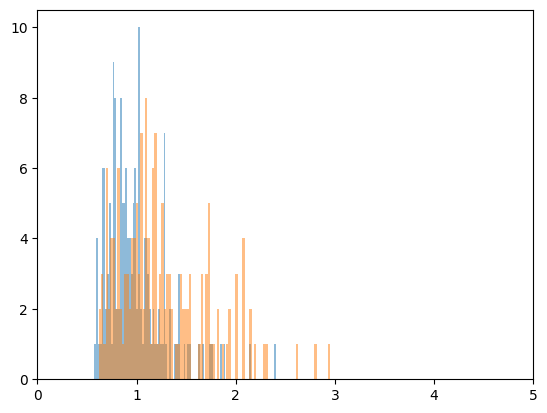

In [18]:
plt.hist(dcm1_errors["mono"], alpha=0.5, bins=100)
plt.hist(dcm1_errors["model"], alpha=0.5, bins=100)
plt.xlim(0, 5)

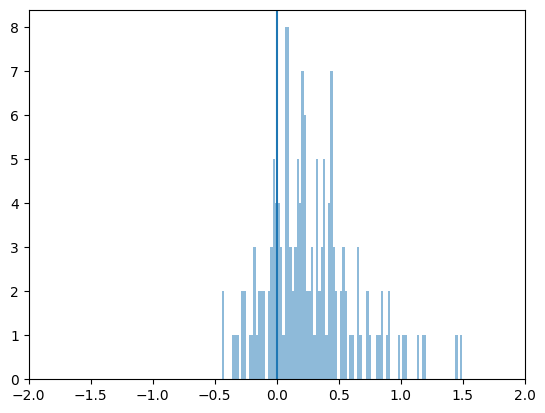

In [19]:
_ =  plt.hist(dcm1_errors["dif"], alpha=0.5, bins=100)
plt.xlim(-2,2)
plt.axvline(0)

# DCM2

In [20]:
get_lowest_loss("checkpoints/dcm2-10000.0/", df=True)

0         1
104  checkpoints/dcm2-10000.0/3-0.02541701868176460...  0.025417
60   checkpoints/dcm2-10000.0/4-0.02546586841344833...  0.025466
1    checkpoints/dcm2-10000.0/2-0.02621370926499366...  0.026214
44   checkpoints/dcm2-10000.0/1-0.03080824203789234...  0.030808
107  checkpoints/dcm2-10000.0/11-0.0334031544625759...  0.033403
..                                                 ...       ...
87   checkpoints/dcm2-10000.0/16-0.1898202747106552...   0.18982
2    checkpoints/dcm2-10000.0/15-0.1906839013099670...  0.190684
27   checkpoints/dcm2-10000.0/18-0.2144098132848739...   0.21441
50   checkpoints/dcm2-10000.0/17-0.2209223806858062...  0.220922
70   checkpoints/dcm2-10000.0/19-0.2587521076202392...  0.258752

[110 rows x 2 columns]

In [21]:
# Model hyperparameters.
features = 32
max_degree = 2
num_iterations = 3
num_basis_functions = 16
cutoff = 4.0

n_dcm = 2
# Training hyperparameters.
learning_rate = 0.001
batch_size = 16
esp_w = 10.0
restart_params = None
num_epochs = 20

# Create and train model.
message_passing_model = MessagePassingModel(
    features=features,
    max_degree=max_degree,
    num_iterations=num_iterations,
    num_basis_functions=num_basis_functions,
    cutoff=cutoff,
    n_dcm=n_dcm,
)

# params = pd.read_pickle("checkpoints/dcm2-10000.0/2-0.026213709264993668-esp_params.pkl")
params = pd.read_pickle(get_lowest_loss("checkpoints/dcm2-10000.0/"))
# params = pd.read_pickle("checkpoints/dcm2-10000.0/7-0.0513247549533844-esp_params.pkl")
# params = pd.read_pickle("checkpoints/dcm2-10.0/99-0.00013578754442278296-esp_params.pkl")

# params = pd.read_pickle("checkpoints/dcm2-1000.0/1-0.005339722149074078-esp_params.pkl")
# params = pd.read_pickle("checkpoints/dcm2-1000.0/26-0.008979301899671555-esp_params.pkl")

# params = pd.read_pickle("checkpoints/dcm2-100.0/25-0.0007704171002842486-esp_params.pkl")



message_passing_model

MessagePassingModel(
    # attributes
    features = 32
    max_degree = 2
    num_iterations = 3
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 2
)

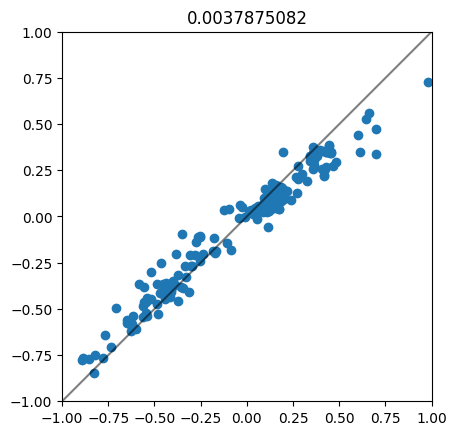

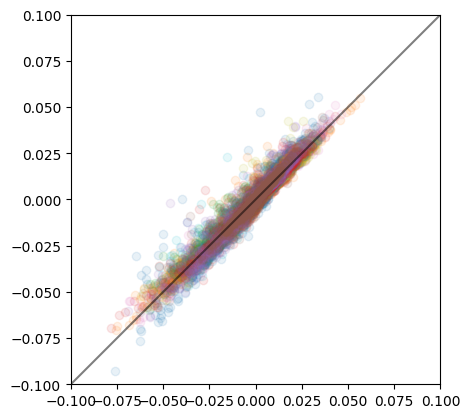

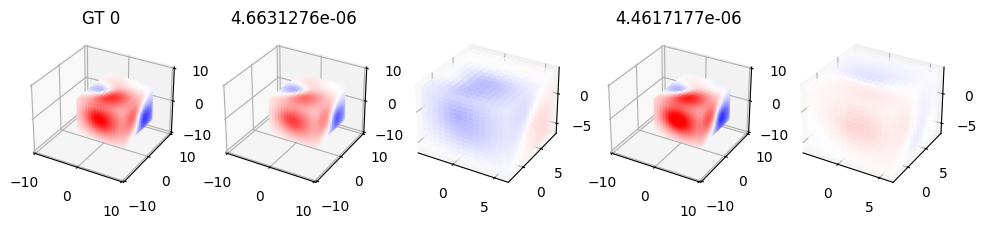

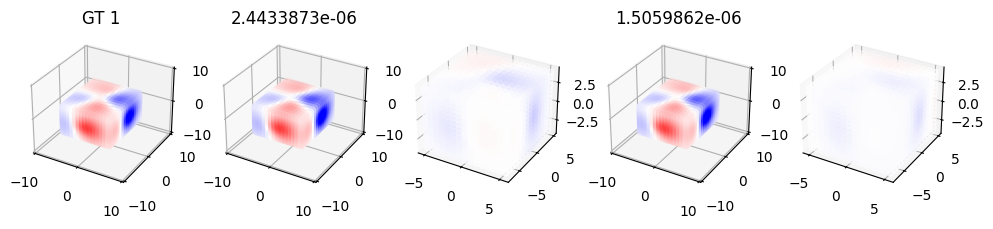

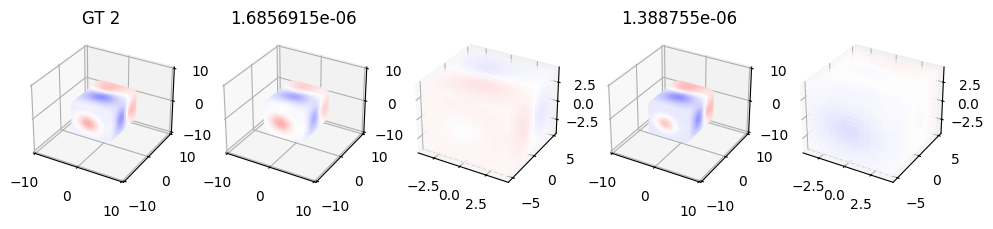

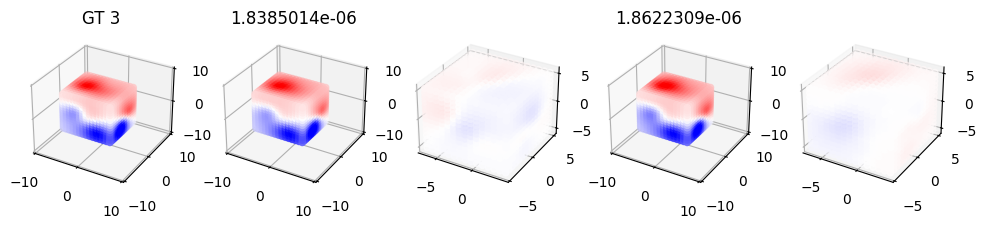

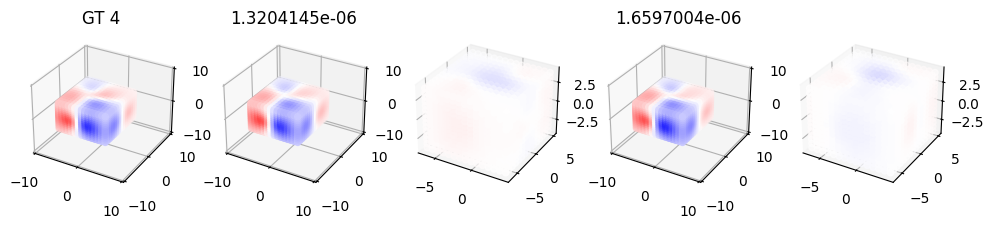

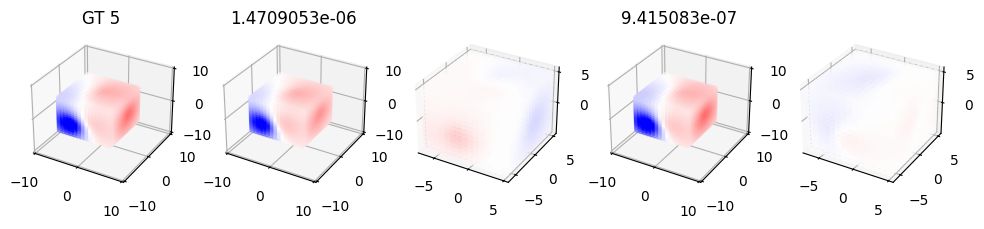

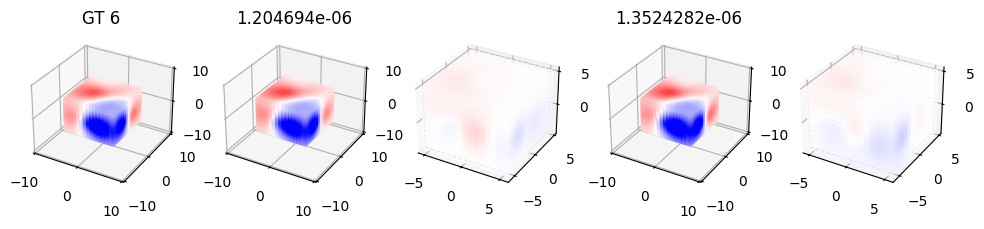

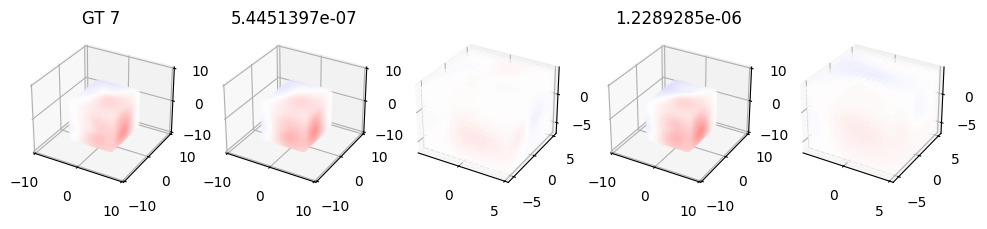

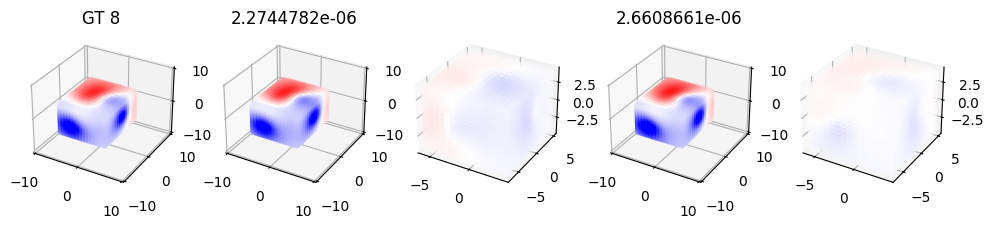

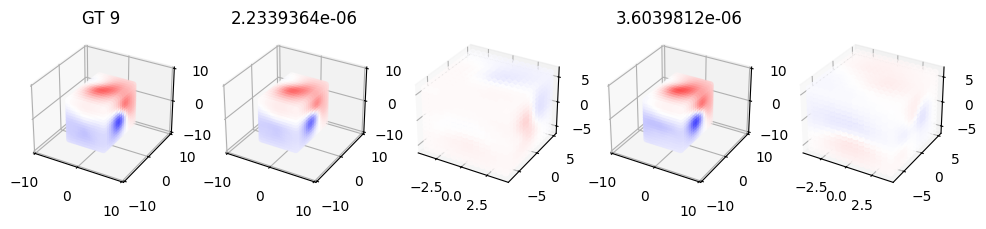

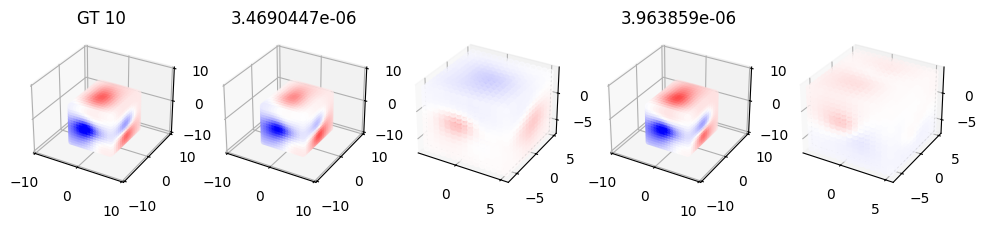

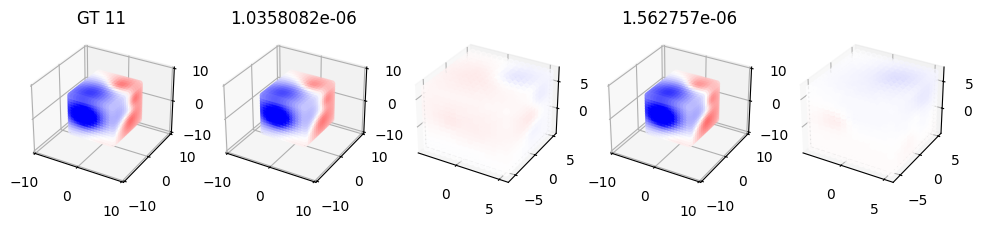

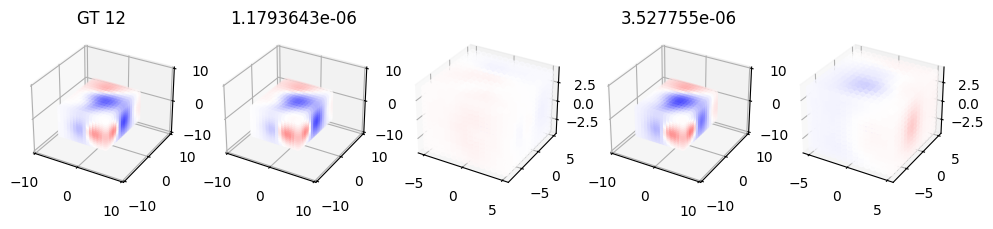

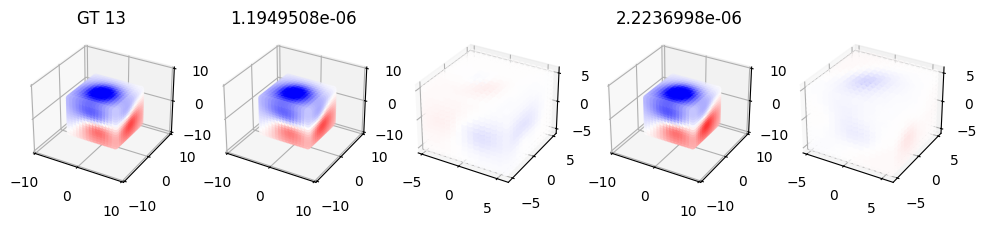

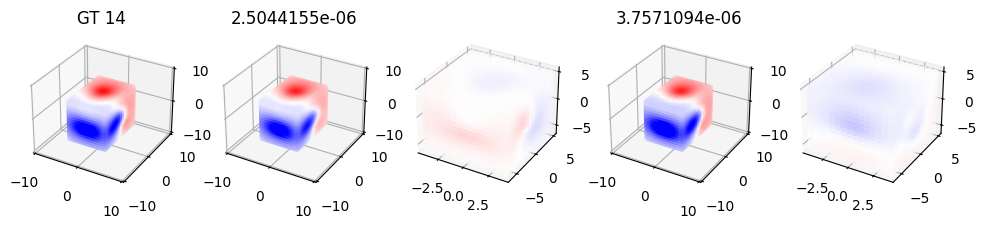

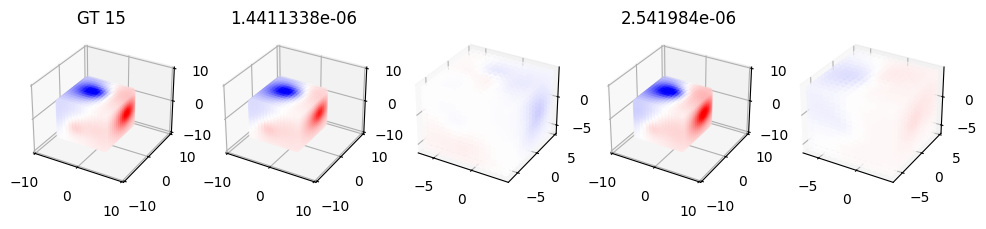

In [22]:
for batchID in range(1):
    batch = valid_batches[batchID]
    
    mono, dipo = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    evaluate_dc(batch, dipo, mono, batch_size, plot=True)

In [23]:
test_error = []

for batchID in range(NTRAINEVAL):
    batch = train_batches[batchID]
    
    mono, dipo = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    error = evaluate_dc(batch, dipo, mono, batch_size)
    test_error.append(error)

In [24]:
dcm2_errors = process_df(test_error)

In [25]:
dcm2_errors.describe()

model        mono         dif
count  160.000000  160.000000  160.000000
mean     0.887371    0.991943   -0.104572
std      0.342891    0.302645    0.231356
min      0.410038    0.576099   -0.700563
25%      0.649294    0.782169   -0.244105
50%      0.811934    0.930883   -0.127376
75%      1.051276    1.102676    0.016663
max      2.274850    2.408691    0.643008

(0.0, 5.0)

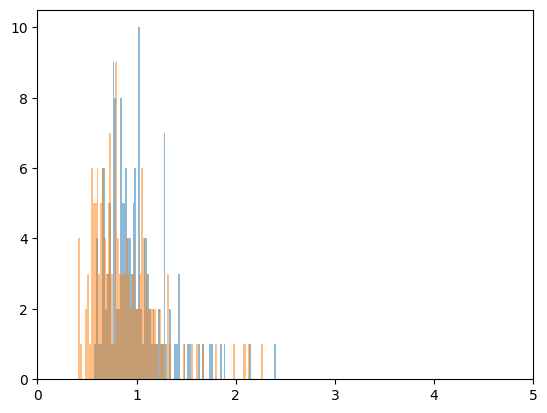

In [26]:
plt.hist(dcm2_errors["mono"], alpha=0.5, bins=100)
plt.hist(dcm2_errors["model"], alpha=0.5, bins=100)
plt.xlim(0, 5)

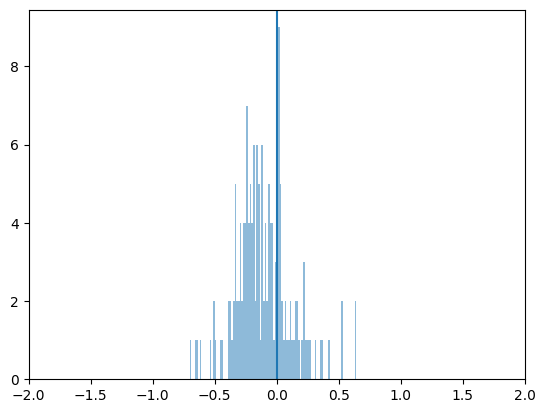

In [27]:
_ =  plt.hist(dcm2_errors["dif"], alpha=0.5, bins=100)
plt.xlim(-2,2)
plt.axvline(0)

#  DCM3

In [28]:
get_lowest_loss("checkpoints/dcm3-10000.0/", df=True)

0         1
7   checkpoints/dcm3-10000.0/8-0.01604942418634891...  0.016049
42  checkpoints/dcm3-10000.0/7-0.01607463322579860...  0.016075
64  checkpoints/dcm3-10000.0/9-0.01608054898679256...  0.016081
13  checkpoints/dcm3-10000.0/6-0.01609916612505912...  0.016099
50  checkpoints/dcm3-10000.0/10-0.0161052606999874...  0.016105
..                                                ...       ...
38  checkpoints/dcm3-10000.0/5-0.04499354213476181...  0.044994
32  checkpoints/dcm3-10000.0/3-0.04571130126714706...  0.045711
9   checkpoints/dcm3-10000.0/2-0.05206951498985290...   0.05207
23  checkpoints/dcm3-10000.0/1-0.06291992217302322...   0.06292
73  checkpoints/dcm3-10000.0/0-0.08970321714878082...  0.089703

[89 rows x 2 columns]

In [29]:
# Model hyperparameters.
features = 32
max_degree = 2
num_iterations = 3
num_basis_functions = 16
cutoff = 4.0

n_dcm = 3
# Training hyperparameters.
learning_rate = 0.001
batch_size = 16
esp_w = 10.0
restart_params = None
num_epochs = 20

# Create and train model.
message_passing_model = MessagePassingModel(
    features=features,
    max_degree=max_degree,
    num_iterations=num_iterations,
    num_basis_functions=num_basis_functions,
    cutoff=cutoff,
    n_dcm=n_dcm,
)

params = pd.read_pickle(get_lowest_loss("checkpoints/dcm3-10000.0/"))
# params = pd.read_pickle("checkpoints/dcm3-10000.0/3-0.01621761918067932-esp_params.pkl")
# params = pd.read_pickle("checkpoints/dcm3-10.0/17-0.0001334990083705634-esp_params.pkl")
# params = pd.read_pickle("checkpoints/dcm3-1000.0/26-0.0028469625394791365-esp_params.pkl")
# params = pd.read_pickle("checkpoints/dcm3-100.0/14-0.0007971551967784762-esp_params.pkl")
message_passing_model

MessagePassingModel(
    # attributes
    features = 32
    max_degree = 2
    num_iterations = 3
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 3
)

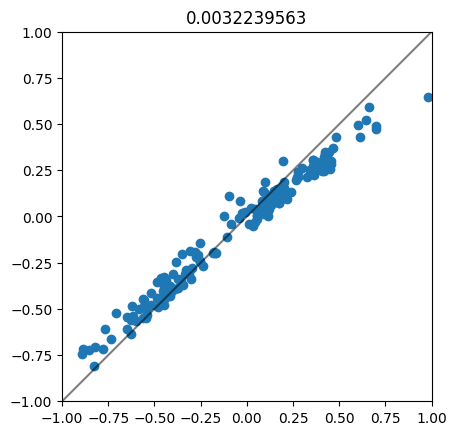

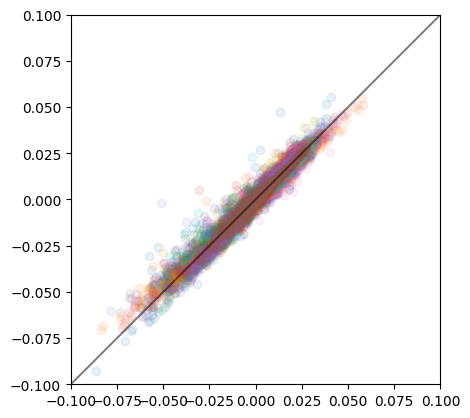

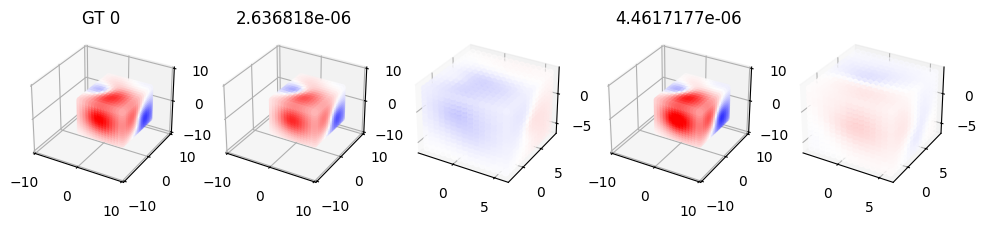

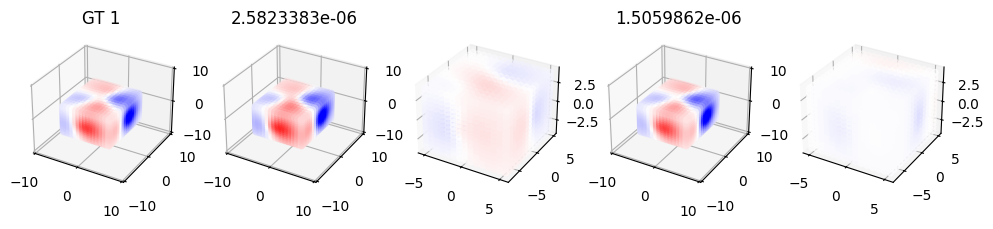

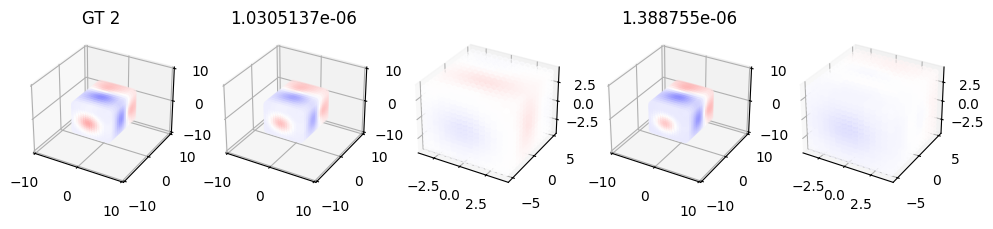

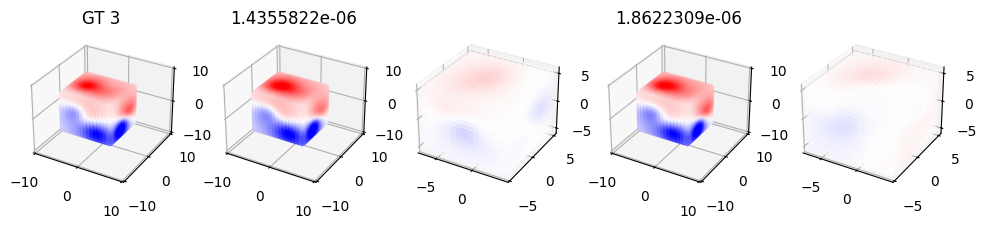

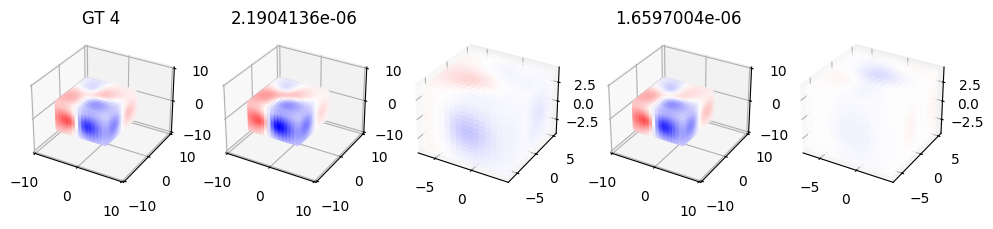

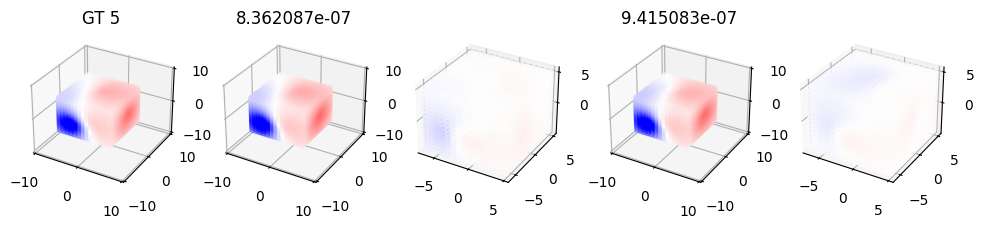

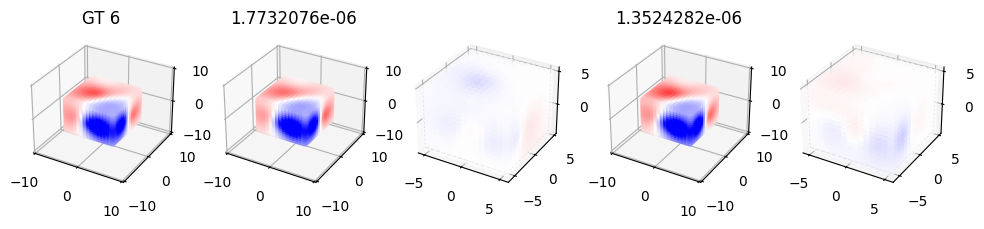

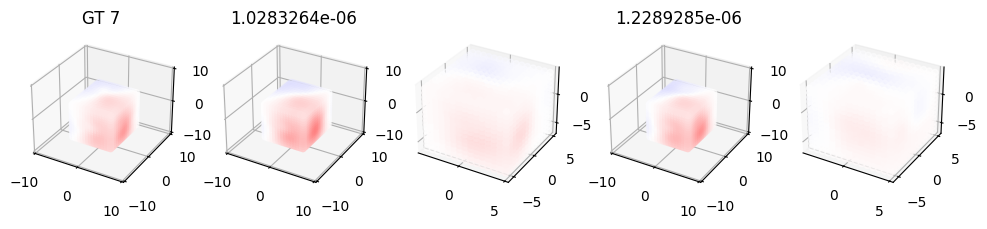

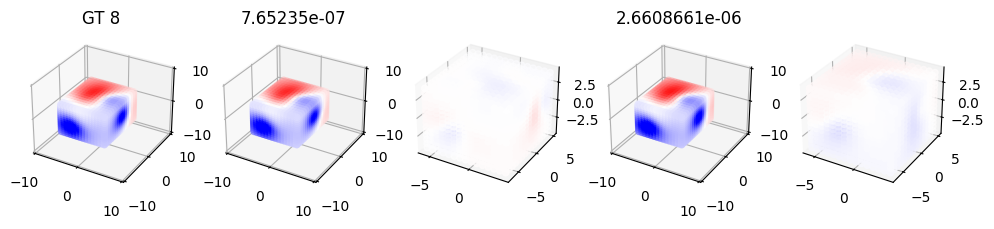

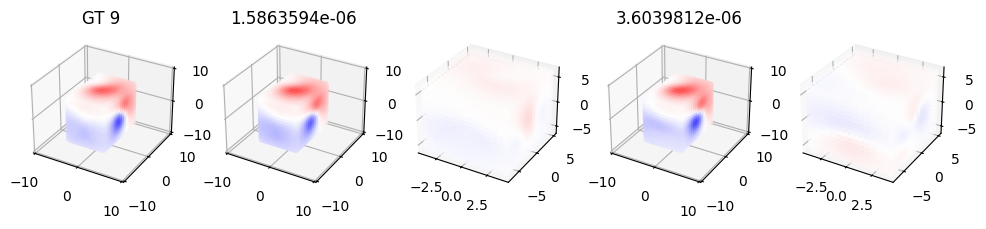

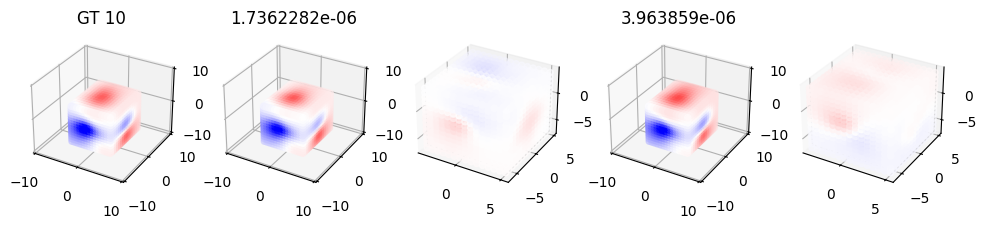

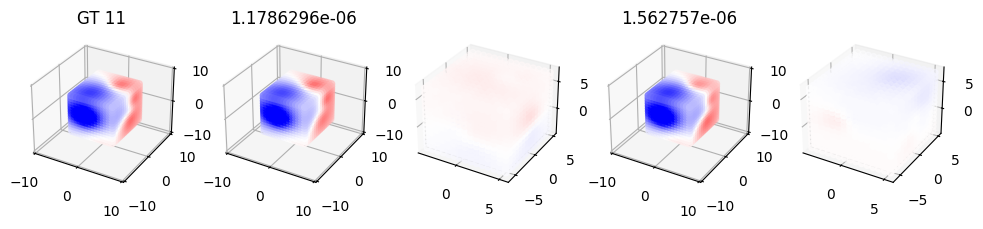

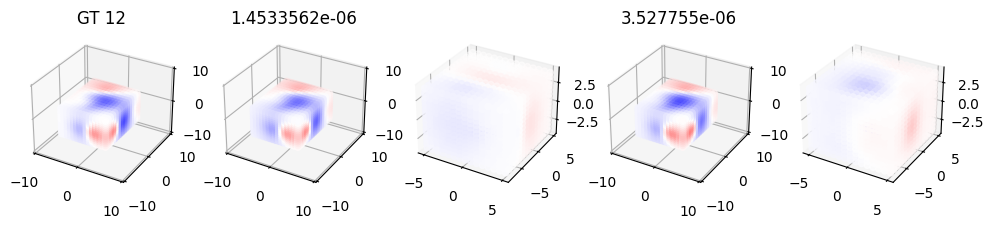

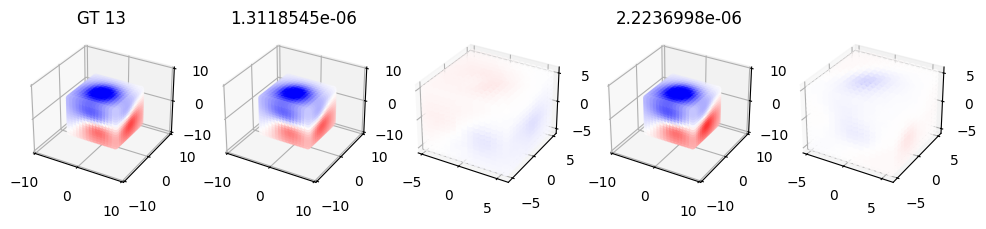

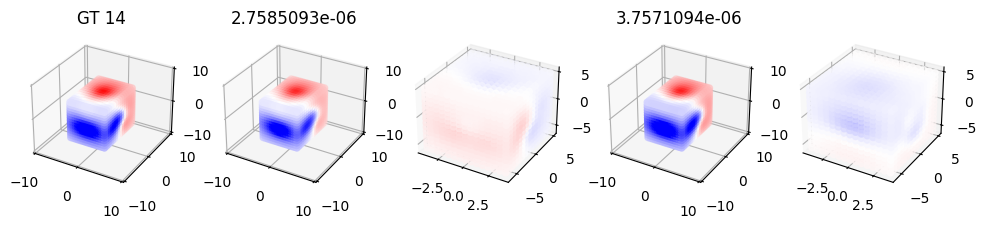

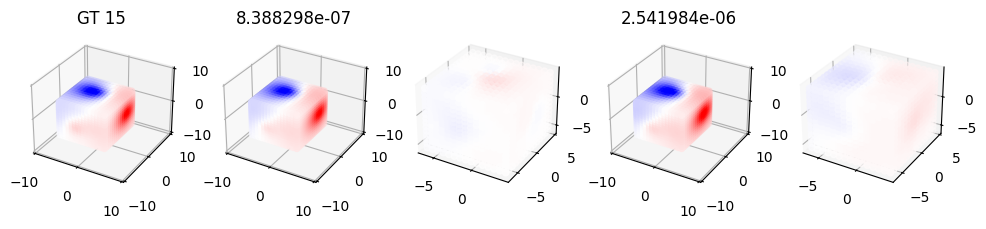

In [30]:
for batchID in range(1):
    batch = valid_batches[batchID]
    
    mono, dipo = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    evaluate_dc(batch, dipo, mono, batch_size, plot=True)

In [31]:
test_errors = []

for batchID in range(NTRAINEVAL):
    batch = train_batches[batchID]
    
    mono, dipo = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    errors = evaluate_dc(batch, dipo, mono, batch_size)
    test_errors.append(errors)

In [32]:
dcm3_errors = process_df(test_errors)

In [33]:
dcm3_errors.describe()

model        mono         dif
count  160.000000  160.000000  160.000000
mean     0.723396    0.991943   -0.268546
std      0.296978    0.302645    0.225296
min      0.280116    0.576099   -0.868127
25%      0.512460    0.782169   -0.373961
50%      0.632268    0.930883   -0.273318
75%      0.862668    1.102676   -0.148577
max      2.022902    2.408691    0.926821

(0.0, 5.0)

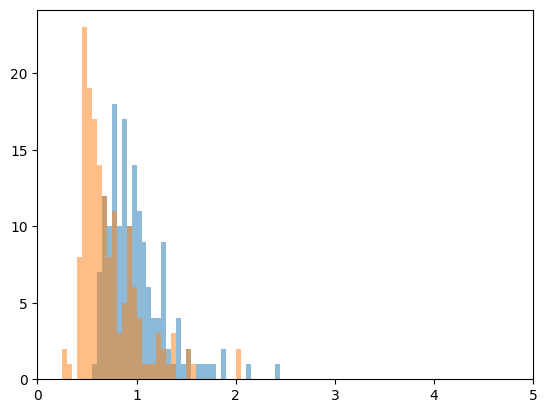

In [34]:
plt.hist(dcm3_errors["mono"], alpha=0.5, bins=100, range=(0,5))
plt.hist(dcm3_errors["model"], alpha=0.5, bins=100, range=(0,5))
plt.xlim(0, 5)

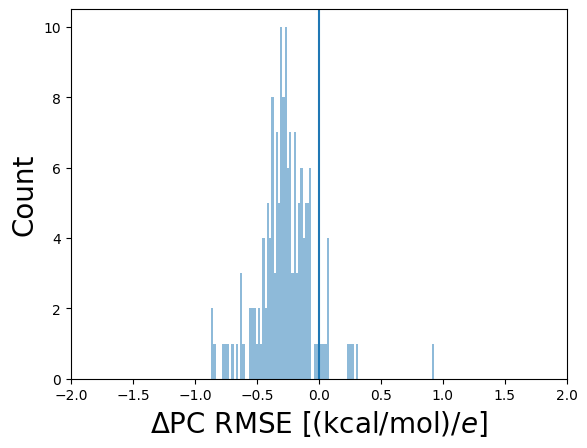

In [35]:
_ =  plt.hist(dcm3_errors["dif"], alpha=0.5, bins=100)
plt.xlim(-2,2)
plt.axvline(0)
plt.ylabel("Count", fontsize=20)
plt.xlabel("$\Delta$PC RMSE [(kcal/mol)/$e$]", fontsize=20)
plt.savefig("deltaESP-dcm3.pdf", bbox_inches="tight")

#  DCM4

In [36]:
# Model hyperparameters.
features = 32
max_degree = 2
num_iterations = 3
num_basis_functions = 16
cutoff = 4.0

n_dcm = 4
# Training hyperparameters.
learning_rate = 0.001
batch_size = 16
esp_w = 10.0
restart_params = None
num_epochs = 20

# Create and train model.
message_passing_model = MessagePassingModel(
    features=features,
    max_degree=max_degree,
    num_iterations=num_iterations,
    num_basis_functions=num_basis_functions,
    cutoff=cutoff,
    n_dcm=n_dcm,
)

params = pd.read_pickle("checkpoints/dcm4-10000.0/1-0.01563119888305664-esp_params.pkl")

# params = pd.read_pickle("checkpoints/dcm4-10.0/25-0.00011416388588258997-esp_params.pkl")

# params = pd.read_pickle("checkpoints/dcm4-100.0/14-0.0007527425768785179-esp_params.pkl")
# 

message_passing_model

MessagePassingModel(
    # attributes
    features = 32
    max_degree = 2
    num_iterations = 3
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 4
)

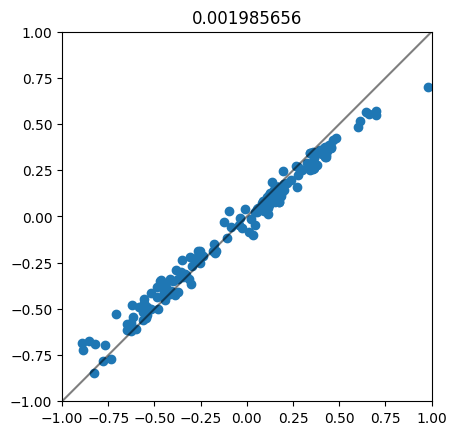

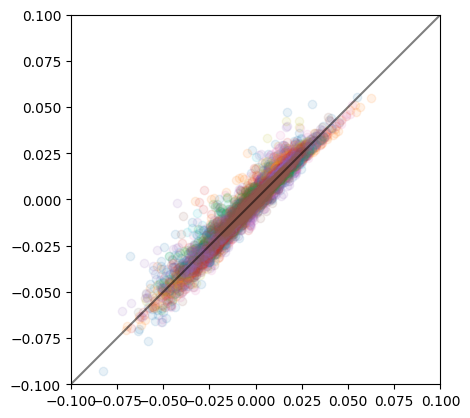

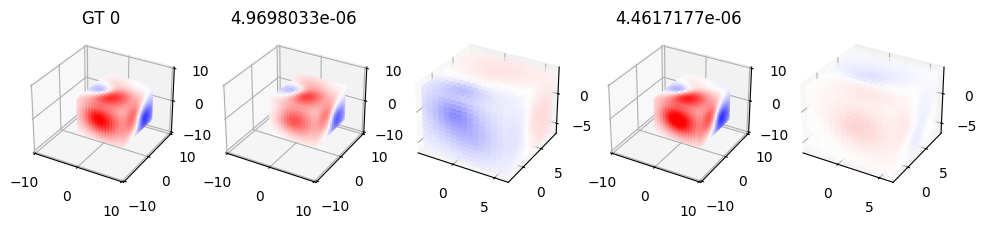

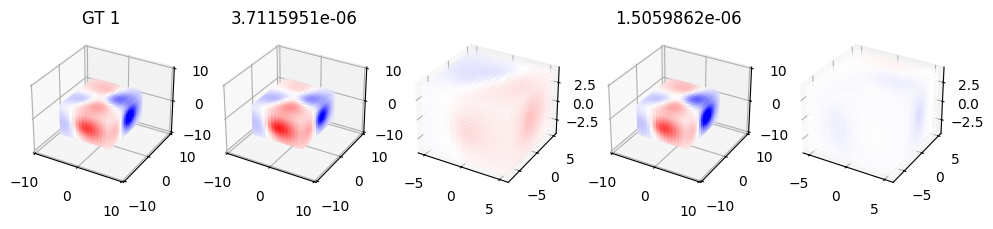

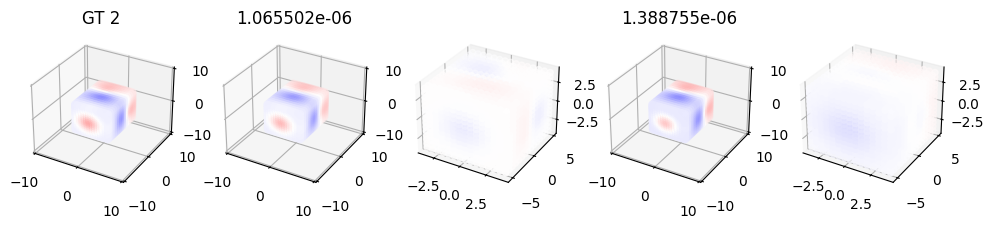

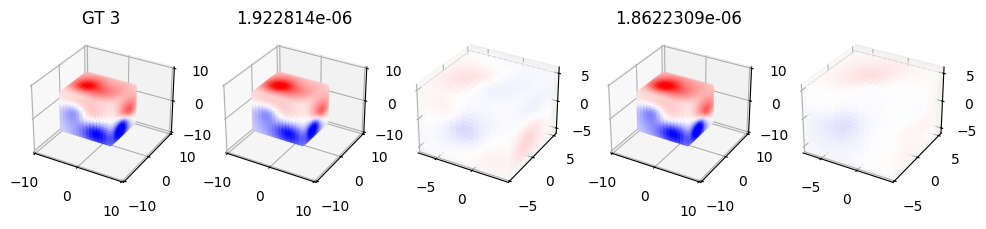

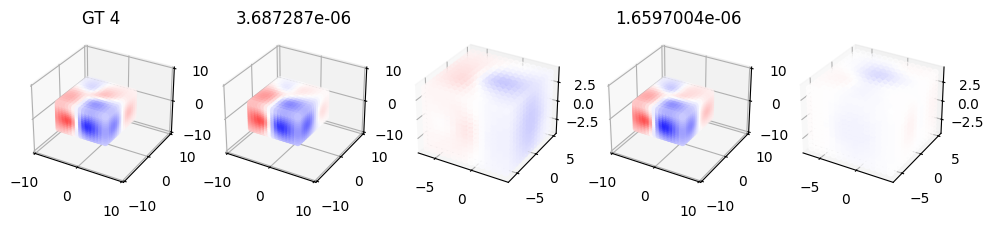

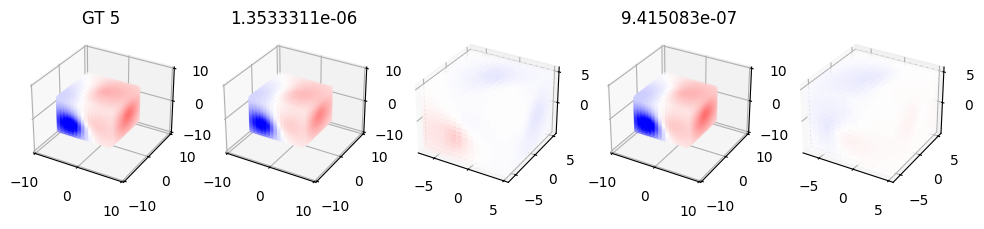

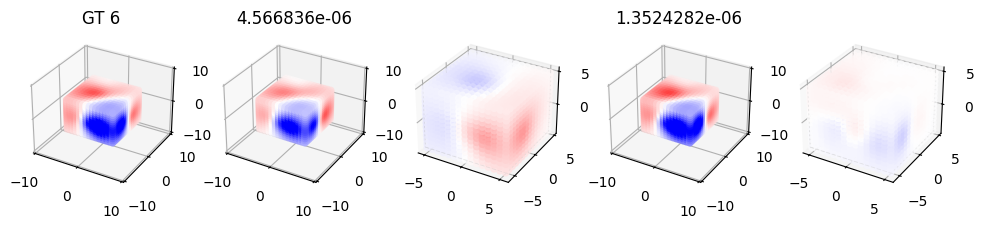

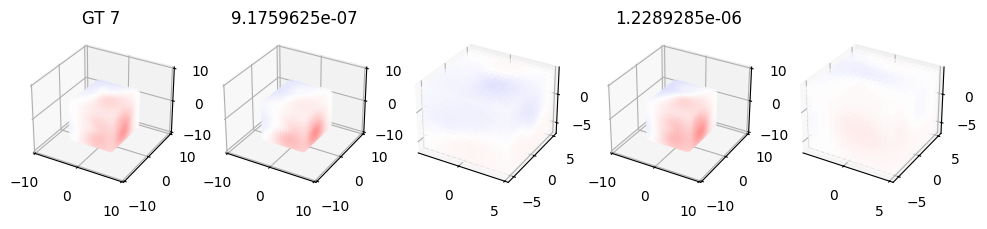

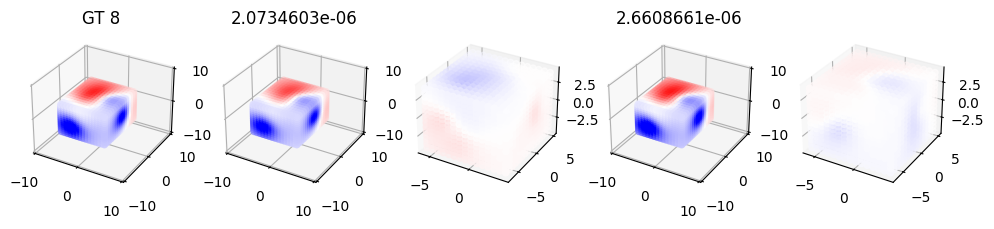

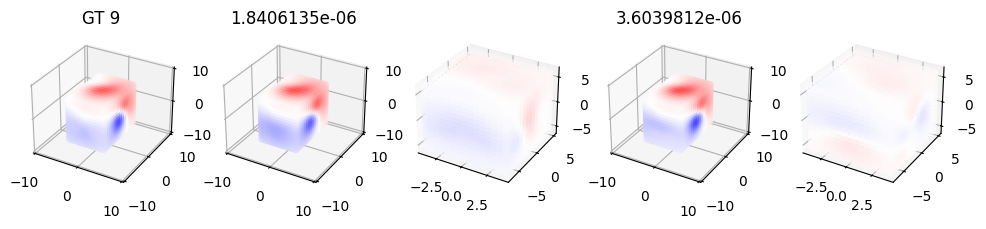

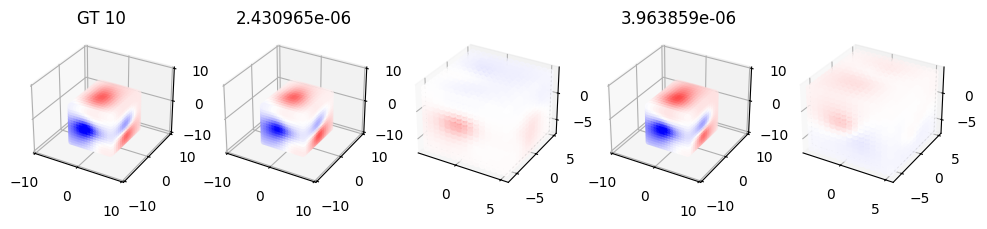

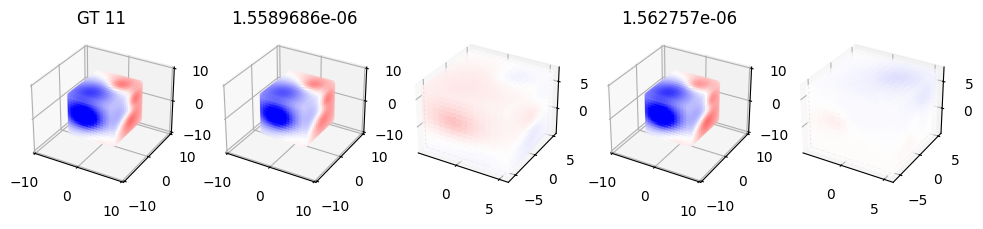

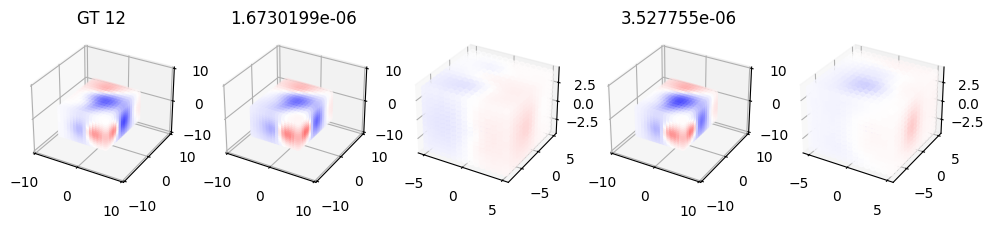

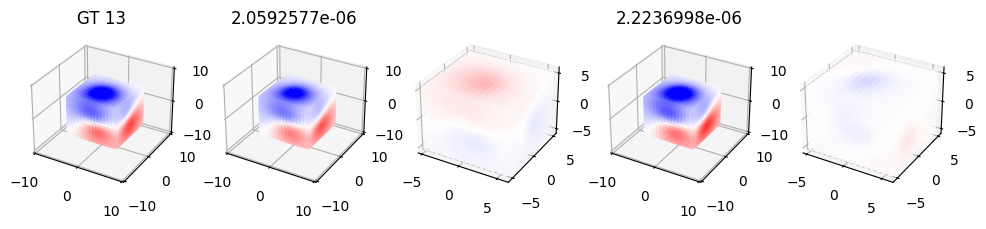

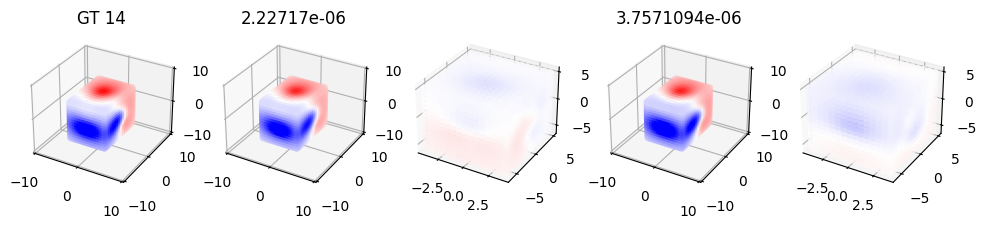

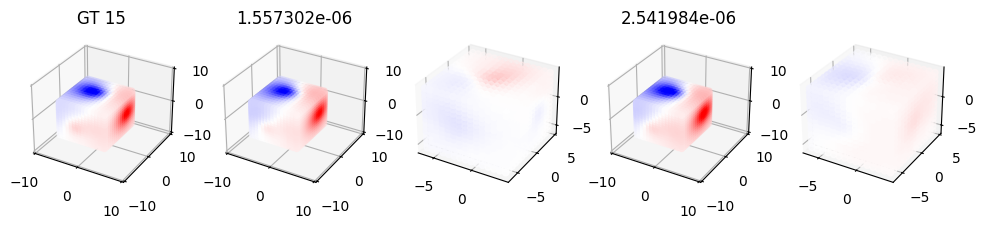

In [37]:
for batchID in range(1):
    batch = valid_batches[batchID]
    
    mono, dipo = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    evaluate_dc(batch, dipo, mono, batch_size, plot=True)

In [38]:
test_errors = []

for batchID in range(NTRAINEVAL):
    batch = train_batches[batchID]
    
    mono, dipo = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    errors = evaluate_dc(batch, dipo, mono, batch_size)
    test_errors.append(errors)

In [39]:
dcm4_errors = process_df(test_errors)

In [40]:
dcm4_errors.describe()

model        mono         dif
count  160.000000  160.000000  160.000000
mean     0.746616    0.991943   -0.245326
std      0.265279    0.302645    0.272867
min      0.385792    0.576099   -1.128442
25%      0.570319    0.782169   -0.380494
50%      0.699399    0.930883   -0.243934
75%      0.835490    1.102676   -0.126026
max      2.106994    2.408691    0.816750

(0.0, 5.0)

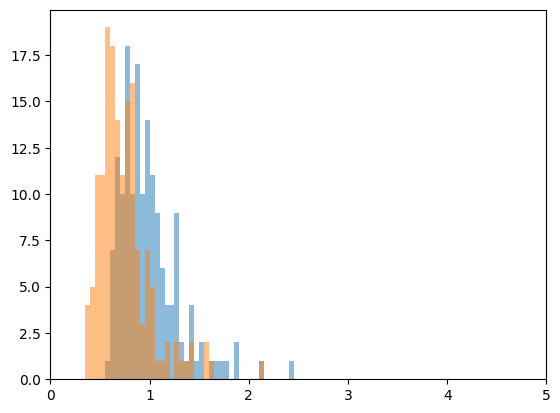

In [41]:
plt.hist(dcm4_errors["mono"], alpha=0.5, bins=100, range=(0,5))
plt.hist(dcm4_errors["model"], alpha=0.5, bins=100, range=(0,5))
plt.xlim(0, 5)

Text(0.5, 0, '$\\Delta$PC RMSE [(kcal/mol)/$e$]')

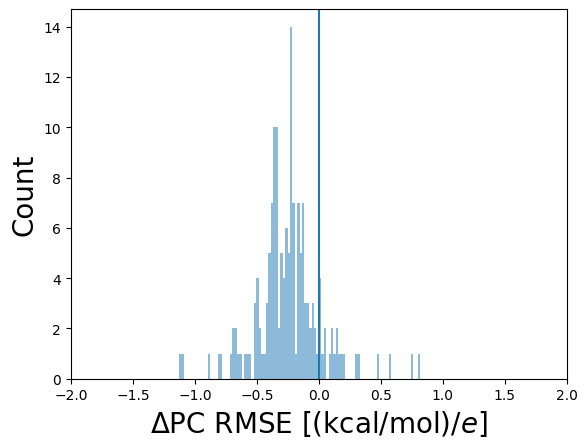

In [42]:
_ =  plt.hist(dcm4_errors["dif"], alpha=0.5, bins=100)
plt.xlim(-2,2)
plt.axvline(0)
plt.ylabel("Count", fontsize=20)
plt.xlabel("$\Delta$PC RMSE [(kcal/mol)/$e$]", fontsize=20)

#  Structures

In [44]:
i = 0
a1_ = mono.reshape(batch_size, 60, n_dcm)[i]
b1_ = batch['atomic_numbers'].reshape(batch_size, 60)[i]
c1_ = batch["mono"].reshape(batch_size, 60)[i]
nonzero = np.nonzero(c1_)

total = 0.0
total_mono = 0.0

for j, l, k in zip(a1_[nonzero], b1_[nonzero], c1_[nonzero]):
    print(j, j.sum(), l, k, abs(j.sum() - k))
    total += j.sum()
    total_mono += k
    
print(total, total_mono)
dc = dipo.reshape(batch_size,60,3,n_dcm)
dc = np.moveaxis(dc, -1, -2)
dc = dc.reshape(batch_size, 60*n_dcm, 3)
dcq = mono.reshape(batch_size,60*n_dcm,1)
dcq = np.moveaxis(dcq, -1, -2)
dcq = dcq.reshape(batch_size, 60*n_dcm, 1)

[-0.08882852 -0.00054166 -0.0093766  -0.13488705] -0.23363383 6 -0.22518945 0.008444384
[-0.11590716 -0.0058777   0.00454773 -0.1191128 ] -0.23634994 6 -0.26071668 0.024366736
[-0.0278604   0.03232519 -0.0067329   0.06517903] 0.06291092 6 0.11414604 0.051235117
[-0.16922131  0.07213656  0.00039638 -0.10499747] -0.20168585 6 -0.27444983 0.07276398
[-0.13829577 -0.00790979  0.01432402 -0.11797665] -0.2498582 6 -0.2744358 0.024577588
[-0.14260136  0.02557687  0.00983616 -0.11063869] -0.21782702 6 -0.22518314 0.007356122
[-0.14134075 -0.00655742  0.01159293 -0.10484925] -0.24115449 6 -0.26070777 0.019553274
[ 0.00500884  0.09218248  0.04647302 -0.03725142] 0.10641292 1 0.119981736 0.013568819
[-0.00537239  0.08091015  0.04269332 -0.01047155] 0.10775954 1 0.109666616 0.001907073
[-0.00300893  0.0680031   0.05280207 -0.01452814] 0.10326811 1 0.12102124 0.017753132
[-0.00106889  0.06260292  0.05998904 -0.01820818] 0.103314884 1 0.11308715 0.0097722635
[-0.00884599  0.04634554  0.02580913 -0.0

In [45]:
xyz = batch['positions'].reshape(batch_size,60,3)[i][nonzero]
elem = batch["atomic_numbers"].reshape(batch_size,60)[i][nonzero]
from ase import Atoms
from ase.visualize import view
mol = Atoms(elem, xyz)
view(mol, viewer="x3d")

In [46]:
idx = len(nonzero[0])*n_dcm
dcmol = Atoms(["X" if _ > 0 else "He" for _ in dcq[i][:idx]], dc[i][:idx])
view(dcmol, viewer="x3d")

In [47]:
combined = dcmol + mol
view(combined, viewer="x3d")

In [106]:
(dipo - batch['positions'][:,:,None]).reshape(batch_size, 60, 3, n_dcm)[i][nonzero]

Array([[[-0.05379552,  0.38910925],
        [ 0.20788324, -0.20164084],
        [ 0.05983627, -0.10702422]],

       [[ 0.0078069 ,  0.0354958 ],
        [ 0.03067648,  0.19867694],
        [-0.02934138,  0.02269125]],

       [[ 0.23322809, -0.15291083],
        [ 0.02097082, -0.15194166],
        [-0.12761497,  0.00079983]],

       [[ 0.02715397, -0.03133237],
        [-0.14246202,  0.07534981],
        [ 0.06221795, -0.03670979]],

       [[ 0.24083471, -0.23679137],
        [-0.22206116,  0.07538247],
        [-0.10877824,  0.23884583]],

       [[ 0.07371414, -0.2916819 ],
        [ 0.04353428, -0.34529305],
        [-0.10306382,  0.5192182 ]],

       [[-0.1384973 ,  0.09650433],
        [ 0.17253923, -0.24090433],
        [ 0.04580188,  0.03617692]],

       [[-0.05632079,  0.19634688],
        [-0.04903507, -0.0748105 ],
        [ 0.04658115, -0.34624612]],

       [[-0.0011861 ,  0.02788299],
        [ 0.05836819, -0.25642693],
        [-0.00340807,  0.17455965]],

       [[-

# Equivariance 

In [78]:
key, rotation_key = jax.random.split(data_key)
rotation = e3x.so3.random_rotation(rotation_key, perturbation=1) 
rotation



Array([[ 0.05267996,  0.32747048, -0.9433917 ],
       [ 0.91801924, -0.38768542, -0.08331037],
       [-0.39302087, -0.861663  , -0.32104754]], dtype=float32)

In [79]:
for batchID in range(1):
    batch = valid_batches[batchID]
    
    mono_rot, dipo_rot = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions']@rotation,
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    # evaluate_dc(batch, dipo, mono, batch_size)

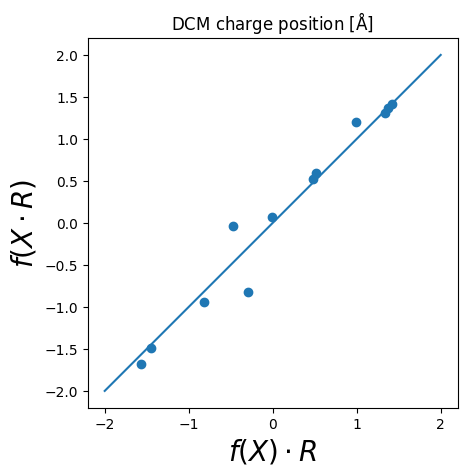

In [80]:
plt.scatter((dipo[0].T  @ rotation).flatten(), dipo_rot[0].T.flatten() )
plt.plot([-2,2],[-2,2])
# plt.xlim(-1.25,1.25)
# plt.ylim(-1.25,1.25)
plt.xlabel('$f(X) \cdot R$', fontsize=20)
plt.ylabel('$f(X \cdot R)$', fontsize=20)
plt.title("DCM charge position [$\mathrm{\\AA}$]")
ax = plt.gca()
ax.set_aspect("equal")
plt.savefig("dcm-equiv.pdf", bbox_inches="tight")

In [81]:
(dipo[0].T  @ rotation).flatten()

Array([ 1.3314071 , -1.5655669 ,  0.5147361 ,  1.423532  , -0.8150511 ,
       -0.01248009,  0.99395746, -0.29163098, -0.46901885,  1.3685436 ,
       -1.4526703 ,  0.48365667], dtype=float32)

In [82]:
dipo_rot[0].T.flatten()

Array([ 1.3038645 , -1.6796789 ,  0.58960915,  1.416168  , -0.93598044,
        0.07539186,  1.2041425 , -0.8264991 , -0.04027677,  1.3622657 ,
       -1.4889882 ,  0.51830554], dtype=float32)